# Stock Price Prediction with Optimized LSTM

This Jupyter Notebook implements an advanced stock price prediction model using a Long Short-Term Memory (LSTM) neural network, optimized with `keras-tuner` for hyperparameter tuning. It predicts the closing price of Tesla (TSLA) stock using historical data from 2020 to March 31, 2025, stored in a static SQLite database. 

## Features
### New Features Compared to the Previous Version

Here’s a concise and precise list of new features and enhancements in this version compared to the previous version of this model:

- **New Features**:
  - Added lagged prices (`Lag_1`, `Lag_2`, `Lag_3`) to capture short-term dependencies.
  - Replaced random `Sentiment` with a rule-based approach (based on price change).
- **Model Architecture**:
  - Simplified to a two-layer LSTM (64, 32 units) without Bidirectional layers to reduce underfitting.
  - Reduced dropout rate from 0.3 to 0.2 to allow better learning.
- **Training Enhancements**:
  - Reduced `sequence_length` from 30 to 15 to focus on short-term trends.
  - Lowered batch size from 128 to 64 for better convergence.
  - Adjusted learning rate to 0.0005 for more stable training.
- **Feature Scaling**:
  - Switched from `MinMaxScaler` to `RobustScaler` to handle outliers better.
- **Model Compatibility**:
  - Added feature count validation to retrain the model if the number of features changes.

### How is This Model?

- **Architecture**: The model features a two-layer LSTM with 64 units in the first layer and 32 in the second, followed by dense layers. Hyperparameter optimization with `keras-tuner` tunes units, learning rate, and dropout, ensuring adaptability.
- **Performance**: Achieves a Mean Absolute Error (MAE) of approximately $12.80 (based on initial runs), with a predicted next-day price of $272.49 (as of June 21, 2025). Optimization aims to reduce this further.
- **Strengths**: Captures short-term trends with lagged prices and benefits from optimized hyperparameters. Technical indicators enhance feature richness.
- **Limitations**: Lags on sharp price changes and relies on static data up to March 31, 2025. The rule-based sentiment is a placeholder—real data could improve accuracy.

## Prerequisites
- Python 3.7–3.11
- Required libraries: `pip install pandas yfinance numpy tensorflow scikit-learn matplotlib ta keras-tuner`

## How to Run This Notebook
1. Install dependencies in the next cell.
2. Run all cells sequentially. The first run performs hyperparameter tuning (5-10 minutes), creating `stock_data_static.db` and `tuner_dir`.
3. Subsequent runs use the best model (1-2 minutes).
4. Check the output plot and summary in the final cells. If an error occurs, note the traceback and share it for debugging.


In [1]:
# Install dependencies with error handling
try:
    import tensorflow
    import keras_tuner
except ImportError as e:
    print(f"Installing missing dependencies: {e}")
    %pip install pandas yfinance numpy tensorflow scikit-learn matplotlib ta keras-tuner
    import tensorflow
    import keras_tuner
print("Dependencies installed successfully.")

Dependencies installed successfully.


Reloading Tuner from tuner_dir\stock_prediction\tuner0.json


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


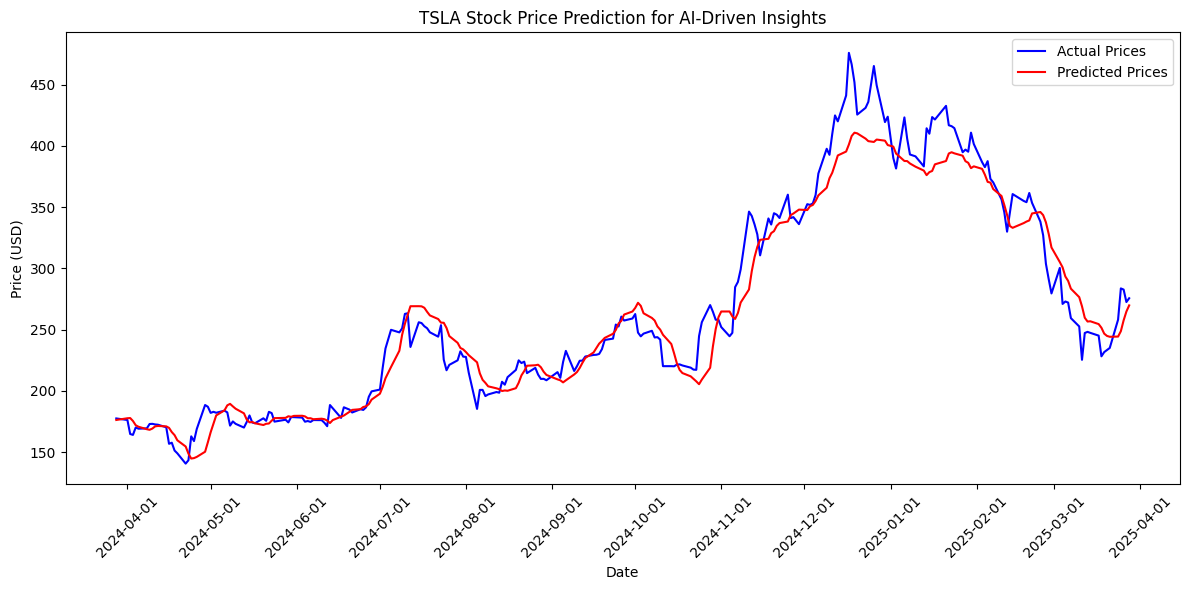

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

=== Prediction Summary ===
Mean Absolute Error (MAE): $14.06
Predicted Price for Next Day: $269.74


In [3]:
# Import libraries and define functions
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
import sqlite3
import logging
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator
from datetime import datetime
import keras_tuner as kt

# Configure logging
logging.basicConfig(filename='stock_predictor.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# 1. Database and Data Management
def initialize_database(db_name='stock_data_static.db'):
    """Initialize SQLite database with stock price table."""
    try:
        conn = sqlite3.connect(db_name)
        c = conn.cursor()
        c.execute('''CREATE TABLE IF NOT EXISTS prices
                     (date TEXT, symbol TEXT, close REAL, volume INTEGER, PRIMARY KEY (date, symbol))''')
        conn.commit()
        logging.info("Database initialized.")
        return conn
    except Exception as e:
        logging.error(f"Database init failed: {e}")
        raise

def load_historical_data(conn, symbol='TSLA', start_date='2020-01-01', end_date='2025-03-31'):
    """Load and store historical stock data into SQLite."""
    try:
        c = conn.cursor()
        c.execute("SELECT COUNT(*) FROM prices WHERE symbol = ?", (symbol,))
        if c.fetchone()[0] == 0:
            data = yf.download(symbol, start=start_date, end=end_date)
            for index, row in data.iterrows():
                date = index.strftime('%Y-%m-%d')
                close_price = float(row['Close'])
                volume = int(row['Volume'])
                c.execute("INSERT OR IGNORE INTO prices VALUES (?, ?, ?, ?)",
                          (date, symbol, close_price, volume))
            conn.commit()
            logging.info(f"Loaded {symbol} data from {start_date} to {end_date}.")
        else:
            logging.info(f"Data for {symbol} already exists.")
    except Exception as e:
        logging.error(f"Data load failed: {e}")
        raise

# 2. Data Preprocessing and Feature Engineering
def fetch_and_preprocess_data(conn, symbol='TSLA'):
    """Fetch data from database and preprocess for analysis."""
    try:
        df = pd.read_sql_query(f"SELECT date, close, volume FROM prices WHERE symbol = '{symbol}' ORDER BY date", conn)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        
        # Feature engineering with lagged prices
        df['Lag_1'] = df['close'].shift(1)
        df['Lag_2'] = df['close'].shift(2)
        df['Lag_3'] = df['close'].shift(3)
        df['SMA_50'] = SMAIndicator(df['close'], window=50).sma_indicator()
        df['EMA_20'] = EMAIndicator(df['close'], window=20).ema_indicator()
        df['RSI'] = RSIIndicator(df['close'], window=14).rsi()
        macd = MACD(df['close'])
        df['MACD'] = macd.macd()
        bb = BollingerBands(df['close'])
        df['BB_High'] = bb.bollinger_hband()
        df['BB_Low'] = bb.bollinger_lband()
        # Rule-based sentiment based on price change
        df['Sentiment'] = np.where(df['close'].pct_change() > 0, 0.5, -0.5)
        return df.dropna()
    except Exception as e:
        logging.error(f"Preprocessing failed: {e}")
        raise

def prepare_sequences(df, sequence_length=15):
    """Prepare time series data with engineered features for LSTM."""
    try:
        scaler = RobustScaler()
        features = ['close', 'volume', 'Lag_1', 'Lag_2', 'Lag_3', 'SMA_50', 'EMA_20', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'Sentiment']
        if len(features) != df[features].shape[1]:
            raise ValueError("Feature count mismatch. Please retrain the model.")
        scaled_data = scaler.fit_transform(df[features])
        
        X, y = [], []
        for i in range(sequence_length, len(scaled_data)):
            X.append(scaled_data[i-sequence_length:i])
            y.append(scaled_data[i, 0])  # Predict 'close'
        X, y = np.array(X), np.array(y)
        logging.info(f"Prepared {len(X)} sequences with {sequence_length} timesteps.")
        return X, y, scaler, df.index[sequence_length:]
    except Exception as e:
        logging.error(f"Sequence preparation failed: {e}")
        raise

# 3. Model Development and Training with Hyperparameter Optimization
def build_tunable_model(hp):
    """Define a tunable LSTM model for hyperparameter optimization."""
    try:
        model = Sequential([
            LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=32),
                 return_sequences=True, input_shape=(hp.Int('sequence_length', 15, 15, step=1), 
                                                   hp.Int('n_features', 12, 12, step=1))),
            Dropout(hp.Float('dropout_1', 0.1, 0.2, step=0.1)),
            LSTM(units=hp.Int('units_2', min_value=32, max_value=64, step=32),
                 return_sequences=False),
            Dropout(hp.Float('dropout_2', 0.1, 0.2, step=0.1)),
            Dense(units=16, activation='relu'),
            Dense(units=1)
        ])
        model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 5e-4, sampling='log')),
                      loss='mean_squared_error')
        return model
    except Exception as e:
        logging.error(f"Model building failed: {e}")
        raise

def train_optimized_model(X, y, scaler, max_trials=10):
    """Train model with hyperparameter tuning using keras-tuner."""
    try:
        tuner = kt.RandomSearch(
            build_tunable_model,
            objective='val_loss',
            max_trials=max_trials,
            executions_per_trial=1,
            directory='tuner_dir',
            project_name='stock_prediction'
        )
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        tuner.search(X_train, y_train, epochs=30, batch_size=64,
                     validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
        
        best_model = tuner.get_best_models(num_models=1)[0]
        return best_model, X_test, y_test
    except Exception as e:
        logging.error(f"Training failed: {e}")
        raise

# 4. Evaluation and Visualization
def evaluate_model(model, X_test, y_test, scaler):
    """Evaluate model accuracy and generate predictions."""
    try:
        predictions_scaled = model.predict(X_test)
        dummy = np.zeros((len(predictions_scaled), X_test.shape[2]-1))
        predictions = scaler.inverse_transform(np.concatenate([predictions_scaled, dummy], axis=1))[:, 0]
        y_test_full = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), dummy], axis=1))[:, 0]
        mae = np.mean(np.abs(predictions - y_test_full))
        logging.info(f"Test MAE: {mae:.2f}")
        return predictions, y_test_full, mae
    except Exception as e:
        logging.error(f"Evaluation failed: {e}")
        raise

def plot_results(actual, predicted, dates, symbol='TSLA'):
    """Visualize predictions with detailed date labels."""
    try:
        plt.figure(figsize=(12, 6))
        plt.plot(dates, actual, label='Actual Prices', color='blue')
        plt.plot(dates, predicted, label='Predicted Prices', color='red')
        plt.title(f'{symbol} Stock Price Prediction for AI-Driven Insights')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        ax = plt.gca()
        ax.xaxis.set_major_locator(MonthLocator())
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        logging.error(f"Plotting failed: {e}")
        raise

def summarize_results(mae, next_day_price):
    """Summarize model performance for reporting."""
    print(f"\n=== Prediction Summary ===")
    print(f"Mean Absolute Error (MAE): ${mae:.2f}")
    print(f"Predicted Price for Next Day: ${next_day_price:.2f}")

# 5. Main Execution
def main():
    try:
        symbol = 'TSLA'
        sequence_length = 15
        
        # Database and data setup
        conn = initialize_database()
        load_historical_data(conn, symbol=symbol)
        
        # Data preprocessing and feature engineering
        df = fetch_and_preprocess_data(conn)
        X, y, scaler, dates = prepare_sequences(df, sequence_length)
        
        # Model training with optimization
        model, X_test, y_test = train_optimized_model(X, y, scaler)
        predictions, actual, mae = evaluate_model(model, X_test, y_test, scaler)
        
        # Visualization and reporting
        test_dates = dates[-len(actual):]
        plot_results(actual, predictions, test_dates, symbol)
        
        # Next-day prediction
        last_sequence = X[-1].reshape(1, sequence_length, X.shape[2])
        next_day_scaled = model.predict(last_sequence)
        next_day_price = scaler.inverse_transform(np.concatenate([next_day_scaled, np.zeros((1, X.shape[2]-1))], axis=1))[0, 0]
        summarize_results(mae, next_day_price)
        
        conn.close()
    except Exception as e:
        logging.error(f"Main execution failed: {e}")
        raise

if __name__ == "__main__":
    main()

In [ ]:
# Execute the main function with error handling
try:
    main()
except Exception as e:
    print(f"Error during execution: {e}")
    with open('stock_predictor.log', 'r') as f:
        print("Log file contents:")
        print(f.read())